In [1]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import random
from scipy import stats
pd.set_option('display.max_columns', 500)
plt.rcParams["figure.figsize"] =(10,6)
#plt.rcParams["axes.labelsize"] = 15
sns.set_style('white')
sns.despine()
sns.set(style="ticks") 
sns.set_context('talk')

Population Correlation coefficient: 0.5773502691896258
Sample Correlation coefficient: 0.6070462059656389
Population R2: 0.3333333333333334
Sample R2: 0.36850509617727684


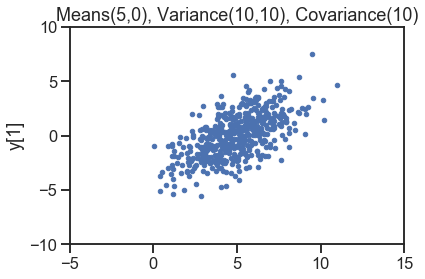

[[1.         0.60704621]
 [0.60704621 1.        ]]


In [441]:
# FROM https://stackoverflow.com/questions/16024677/generate-correlated-data-in-python-3-3
num_samples = 500

# The desired mean values of the sample.
mu = np.array([5.0, 0.0, 4, -4])
mu = np.array([5.0, 0.0])


# The desired covariance matrix.
r = np.array([
        [ 3,  2, 1, 2],
        [ 2,  4, 2, 1],
        [ 1,  2, 2, 2],
        [ 2,  1, 2, 1],
    ])

r = np.array([
        [ 3,  2],
        [ 2,  4],
    ])
#variance_1, covariance
#covariance, variance_2
#always symmetric across diagonal

#TODO nonsensical answers when cov is larger than variance

# covariance cannot be larger than the variance
# 

## cannot interpret covariance easily because it is not normalized
## normalized version is correlation coefficient

# Generate the random samples.
y = np.random.multivariate_normal(mu, r, size=num_samples)

cor_coef = r[0][1]/(np.sqrt(r[0][0])*np.sqrt(r[1][1]))
print('Population Correlation coefficient: %s' % cor_coef)
print('Sample Correlation coefficient: %s' % np.corrcoef(y, rowvar=False)[0][1])
r2 = np.power(r[0][1]/(np.sqrt(r[0][0])*np.sqrt(r[1][1])),2)
print('Population R2: %s' % r2)
print('Sample R2: %s' % np.power(np.corrcoef(y, rowvar=False)[0][1],2))
# Plot various projections of the samples.
#plt.subplot(2,2,1)
plt.title('Means(5,0), Variance(10,10), Covariance(%s)' % i)
plt.xlim((-5,15))
plt.ylim((-10,10))
plt.plot(y[:,0], y[:,1], 'b.')
#plt.plot(mu[0], mu[1], 'ro')
plt.ylabel('y[1]')
#plt.axis('equal')
#plt.grid(True)
plt.show()
print(np.corrcoef(y, rowvar=False))
    
x = (y[:, 1:])
y = (y[:, 0])

In [442]:
#soap	suds
#x = np.array([4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0])
#y = np.array([33, 42, 45, 51, 53, 61, 62])

In [443]:
# theres a much simpler function here with one of the np randoms im sure

def bootstrap_sample(x,y,n):
    samples_x = [[]]*n
    samples_y = [[]]*n
    for i in range(n):
        if x.shape != ():
            samples_x[i] = np.ndarray(x.shape)
        else:
            samples_x[i] = np.ndarray([])
        samples_y[i] = np.ndarray(y.shape)
        for _ in range(y.shape[0]):
            # lol i was combining random X and random Y before
            chosen_obs = random.randrange(y.shape[0])
            if x.shape != ():
                samples_x[i][_] = x[chosen_obs]
            samples_y[i][_] = y[chosen_obs]
    return (samples_x, samples_y)

In [446]:
class simple_regression:
    x = []
    y = []
    coefs = []
    debug = False
    
    def __init__(self, x, y, debug=False):
        self.debug = debug
        self.x = x
        self.y = y
        self.fit()
    
    def debug_print(self, s):
        if self.debug:
            print(s)
        else:
            pass
        
    def create_design_matrix(self):
        self.debug_print(np.shape(self.x))
        self.debug_print(self.x)
        self.debug_print(np.ones_like(self.y))
        ones = np.ones_like(self.y)
        ones = ones.reshape(self.y.shape[0],1)
        self.debug_print(self.x.shape)
        self.debug_print(type(ones))
        self.debug_print(type(self.x))
        # account for reduced model case here where only fitting an intercept
        if len(self.x.shape) > 0:
            x = np.vstack([ones.T,self.x.T]).T
        else:
            x = ones
        self.debug_print(x)
        self.debug_print('X with padded 1s')
        self.debug_print(x)
        self.debug_print(x.shape)
        return x
    
    def fit(self):
        # we need to add a column of 1s to our X
        #debug_print((np.ones(np.shape(x)[0])))
        x = self.create_design_matrix()
        self.debug_print('X transpose')
        self.debug_print(x.T)
        x_t_x_product = np.matmul(x.T,x)
        self.debug_print('X_t*X')
        self.debug_print(x_t_x_product)
        x_t_x_inverse = np.linalg.inv(x_t_x_product)
        self.debug_print('X_t*X Inverted')
        self.debug_print(x_t_x_inverse)
        self.debug_print('x_t %s' % x.T)
        self.debug_print('y %s' % self.y)
        x_t_times_y = np.matmul(x.T, self.y)
        self.debug_print('X_t * y')
        self.debug_print(x_t_times_y)
        final_with_y = np.matmul(x_t_x_inverse, x_t_times_y.T)
        self.debug_print('Final:')
        self.debug_print(final_with_y)
        self.coefs = final_with_y
        return final_with_y
    
    def get_coefs(self):
        return self.coefs
    
    def residuals(self):
        if len(self.coefs) == 0:
            raise ValueError('Model is not fitted')
        x = self.create_design_matrix()
        predictions = np.matmul(x, self.coefs)
        return self.y - predictions
    
    def sse(self):
        return np.sum(np.power(self.residuals(),2))
    
    def f_test(self):
        reduced_model = simple_regression(np.ndarray([]), self.y, debug=False)
        sse_reduced = reduced_model.sse()
        df_reduced = self.y.shape[0]-1
        sse_full = self.sse()
        if len(self.x.shape) > 0:
            df_full = self.y.shape[0]-self.x.shape[1]-1 # minus 1 is for intercept
        else:
            df_full = self.y.shape[0]-1
        return ((sse_reduced-sse_full)/(df_reduced-df_full))/(sse_full/df_full)
    
    def get_coef_cis(self, n):
        bootstrapped_samples_x, bootstrapped_samples_y = bootstrap_sample(self.x,self.y,n)
        num_betas = self.x.shape[1] if self.x.shape != () else 0
        coef_est = np.ndarray((n,num_betas+1))
        for i,val in enumerate(bootstrapped_samples_x):
            r = simple_regression(bootstrapped_samples_x[i], bootstrapped_samples_y[i])
            coef_est[i] = r.get_coefs()
        return np.apply_along_axis(np.quantile, axis=0, arr=coef_est, q=[.025, .975])
    
    def p_value(self):
        f = self.f_test()
        # why do we need an absolute value on the f stat?
        # lol we don't if we calculate it correctly (reduced - full)
        #print(stats.f.sf((f),self.y.shape[0]-1,self.y.shape[0]-self.x.shape[1]-1))

    def print_summary(self):
        cis = self.get_coef_cis(500).T
        for i, val in enumerate(self.coefs):
            if i == 0:
                print('Intercept: %s,   ci: %s' % (list(self.coefs)[i], cis[i]))
            else:
                print('b_%s coefficient: %s,   ci: %s' % (i, val, cis[i]))
        print('f-statistic: %s' % (self.f_test()))
        print('p-value for f-statistic: %s' % (self.p_value()))
        
test_multiple = simple_regression(x,y, debug=False)
test_multiple.print_summary()
#print(test_multiple.get_coef_cis(200).T[0])
#print(test_multiple.f_test())
#print(test_multiple.p_value())
plt.show()

test_reduced = simple_regression(np.ndarray([]), y, debug=False)
test_reduced.fit()
test_reduced.print_summary()
#print(test_reduced.f_test())
#print(test_reduced.sse())


Intercept: 4.899815660269471,   ci: [4.76661426 5.03103189]
b_1 coefficient: 0.5518355986982935,   ci: [0.48825363 0.61709902]
f-statistic: 290.60493882908935
p-value for f-statistic: None
Intercept: 4.931489158461502,   ci: [4.78053247 5.08018002]
f-statistic: nan
p-value for f-statistic: None


/Users/aaronspringer/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in double_scalars


In [435]:
np.ndarray([]).shape

()

In [447]:
x_1 = (sm.add_constant(x))
#print(np.transpose(sm.add_constant(x)))
#print(y)
sm.OLS(y, sm.add_constant(x)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     290.6
Date:                Mon, 31 May 2021   Prob (F-statistic):           1.15e-51
Time:                        12:04:06   Log-Likelihood:                -903.55
No. Observations:                 500   AIC:                             1811.
Df Residuals:                     498   BIC:                             1820.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8998      0.066     74.139      0.000       4.770       5.030
x1             0.5518      0.032     17.047      0.000       0.488       0.615
==============================================================================
Omnibus:                        1.279   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.527   Jarque-Bera (JB):                1.359
Skew:                           0.116   Prob(JB):                        0.507
Kurtosis:                       2.892   Cond. No.                         2.04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [190]:
#bootstrap doesn't perform super well with suds data
# ^^ remains to be seen
# it didn't perform super well because my bootstrap just chose random shit to fit
bootstrapped_samples_x, bootstrapped_samples_y = bootstrap_sample(x,y,5000)
#print(bootstrapped_samples_x)
intercept_est = []
coef_est = []
for i,val in enumerate(bootstrapped_samples_x):
    intercept_est.append(simple_regression(bootstrapped_samples_x[i], bootstrapped_samples_y[i])[0].item())
    #print(val)
    #print(intercept_est[-1])
    #print(sm.OLS(bootstrapped_samples_y[i], sm.add_constant(bootstrapped_samples_x[i])).fit().summary())
    coef_est.append(simple_regression(val, bootstrapped_samples_y[i])[1].item())

# we can't really treat this as the confidence interval because it is dependent on the number of bootstrap samples
# instead we should just take the 95% quantiles
#print('Intercept 95 confidence interval: (%s, %s)' % (np.mean(intercept_est)-1.96*intercept_se,np.mean(intercept_est)+1.96*intercept_se))
#print('Coef 95 confidence interval: (%s, %s)' % (np.mean(coef_est)-1.96*coef_se,np.mean(coef_est)+1.96*coef_se))
print('Intercept 95 confidence interval: %s' % np.quantile(intercept_est, [.025, .975]))
print('Coef 95 confidence interval: %s' % np.quantile(coef_est, [.025,.975]))

pd.Series(intercept_est).plot.hist()
plt.show()
#sm.qqplot(pd.Series(intercept_est), line='45')
pd.Series(coef_est).plot.hist()
plt.show()
#sm.qqplot(pd.Series(coef_est), line='45')

TypeError: list indices must be integers or slices, not tuple

In [464]:
np.version.version

'1.14.5'